## Accessing NetCDF-formatted Daymet data on Azure

The [Daymet](https://daymet.ornl.gov/) dataset contains daily minimum temperature, maximum temperature, precipitation, shortwave radiation, vapor pressure, snow water equivalent, and day length at 1km resolution for North America. The dataset covers the period from January 1, 1980 to December 31, 2019.

Daymet is available in both NetCDF and Zarr format on Azure; this notebook demonstrates access to the NetCDF data.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [aka.ms/ai4edata-daymet](http://aka.ms/ai4edata-daymet).

### Environment setup

In [1]:
import os
import tempfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

import fsspec
import xarray as xr
from azure.storage.blob import ContainerClient

# Not used directly, but needs to be installed to read NetCDF files with xarray
import h5netcdf

### Constants

In [2]:
# Pick a region, year, and variable to explore 
region = 'hi' # na, hi, pr
year = '2019'
variable = 'tmax' # tmax, tmin, precp, srad, vp, swe, dayl
frequency = 'daily'

 # 'daily' for daily data, 'monttl' or 'monavg' for monthly data, 'annttl' or 'annavg' for annual data
aggregation = 'daily'

storage_account_name = 'daymeteuwest'
container_name = 'daymet-nc'
storage_account_url = 'https://' + storage_account_name + '.blob.core.windows.net/'

### List the available Daymet files for the frequency, region, and year of interest

We're going to build the URL directly in the next cell, this is purely for illustrating container structure.

In [3]:
# List the blobs in the container
container_client = ContainerClient(account_url=storage_account_url, 
                                         container_name=container_name,
                                         credential=None)

generator = container_client.list_blobs()
for blob in generator:
    if region in blob.name and year in blob.name and frequency in blob.name:
        print('Blob name: ' + blob.name)

Blob name: daymet_v4_daily/daymet_v4_daily_hi_dayl_2019.nc
Blob name: daymet_v4_daily/daymet_v4_daily_hi_prcp_2019.nc
Blob name: daymet_v4_daily/daymet_v4_daily_hi_srad_2019.nc
Blob name: daymet_v4_daily/daymet_v4_daily_hi_swe_2019.nc
Blob name: daymet_v4_daily/daymet_v4_daily_hi_tmax_2019.nc
Blob name: daymet_v4_daily/daymet_v4_daily_hi_tmin_2019.nc
Blob name: daymet_v4_daily/daymet_v4_daily_hi_vp_2019.nc


### Choose a specific file

In [4]:
if frequency == 'daily':
    granule_name = 'daymet_v4_daily' + '/' + 'daymet_v4_daily_' + \
    region + '_' + variable + '_' + year + '.nc'
else:
    granule_name = 'daymet_v4_' + frequency + '/' + 'daymet_v4_' + \
    variable + '_' + aggregation + '_' + region + '_' + year + '.nc'
url = storage_account_url + container_name + '/' + granule_name
print('Processing data from:\n{}'.format(url))

Processing data from:
https://daymeteuwest.blob.core.windows.net/daymet-nc/daymet_v4_daily/daymet_v4_daily_hi_tmax_2019.nc


### Open the file and print metadata

In [5]:
with fsspec.open(url) as f:
    ds = xr.open_dataset(f)
print(ds)

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 365, x: 284, y: 584)
Coordinates:
  * x                        (x) float32 -5.802e+06 -5.801e+06 ... -5.519e+06
  * y                        (y) float32 -3.9e+04 -4e+04 ... -6.21e+05 -6.22e+05
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 2019-01-01T12:00:00 ... 20...
Dimensions without coordinates: nv
Data variables:
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    lambert_conformal_conic  int16 ...
    tmax                     (time, y, x) float32 ...
Attributes:
    start_year:        [2019]
    source:            Daymet Software Version 4.0
    Version_software:  Daymet Software Version 4.0
    Version_data:      Daymet Data Version 4.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:    

### Plot the mean of this variable

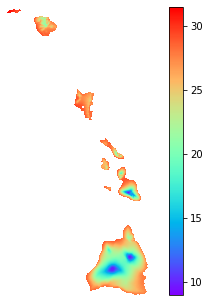

In [6]:
# Read the whole array
data = ds[variable]

# Calculate mean
data_mean = np.mean(data, axis=0)

# Plot
fig = plt.figure(frameon=False); ax = plt.Axes(fig,[0., 0., 1., 1.]); 
ax.set_axis_off(); fig.add_axes(ax)
plt.imshow(data_mean, cmap='rainbow')
plt.colorbar();